In [1]:
from spkit import bkt
import pandas as pd
import re
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pickle

### Reading created files

In [2]:
folder = 'data/kdd/2005-2006'

In [46]:
with open('%s/kdd_2005_2006_test_df.pkl' % folder, 'rb') as pklfile:
    df = pickle.load(pklfile)
with open('%s/kdd_2005_2006_test_data.pkl' % folder, 'rb') as pklfile:
    data = pickle.load(pklfile)
with open('%s/kdd_2005_2006_test_q_matrix.pkl' % folder, 'rb') as pklfile:
    q_matrix = pickle.load(pklfile)
with open('%s/kdd_2005_2006_test_students.pkl' % folder, 'rb') as pklfile:
    students = pickle.load(pklfile)
with open('%s/kdd_2005_2006_kcs.pkl' % folder, 'rb') as pklfile:
    kcs = pickle.load(pklfile)
# Load module
with open('%s/kdd_2005_2006_bkt_model.pkl' % folder, 'rb') as pklfile:
    model = pickle.load(pklfile)
# Load learning states
with open('%s/kdd_2005_2006_bkt_learning_state.pkl' % folder, 'rb') as pklfile:
    learning_state = pickle.load(pklfile)

In [52]:
set(students) - set(learning_state.keys())

set()

In [33]:
len(students)

551

### Calculate score

In [34]:
%%time
data_arr = np.asarray(data)
rmse = 0
n = 0
score_df = []
outcome_all = []
predicted_proba = []
old_students = []
for student in students:
    student_idx = np.where(data_arr[:,1] == student)
    outcome = data_arr[student_idx, 0].astype('int64')
    outcome_all += outcome.tolist()[0]
    question_id = data_arr[student_idx, 2].astype('int64')
    data_student = np.vstack((outcome, question_id)).T.astype('int64').tolist()
    
    # Already seen the student, get last learning state
    if student in learning_state.keys():
        predicted = model.predict_proba(data_student, q_matrix, learning_state[student])
        old_students.append(student)
    # New student, use default learning state
    else:
        predicted = model.predict_proba(data_student, q_matrix)
    
    # Predict student probability of getting incorrect and correct outcome
    predicted_proba += predicted[:,1].tolist()
    # Calculate model score for given student
    ll_aic, s_aic, s_bic, s_rmse, s_acc = model.score()
    fpr, tpr, _ = roc_curve(outcome.flatten(), predicted[:,1], pos_label=1)
    auc_score = auc(fpr, tpr)
    
    # Save score data
    score_df.append({"student": student,
                     "AIC": s_aic,
                     "BIC": s_bic,
                     "RMSE": s_rmse,
                     "Acc": s_acc,
                     "n questions": model.n_questions,
                     "LL": ll_aic,
                     "correct_outcome": np.where(outcome == 1)[1].shape[0],
                     "incorrect_outcome": np.where(outcome == 0)[1].shape[0],
                     "AUC": auc_score})
    learning_state[student] = model.learning_state

CPU times: user 812 ms, sys: 0 ns, total: 812 ms
Wall time: 807 ms


In [35]:
score = pd.DataFrame.from_dict(score_df)

In [36]:
rmse_train = np.sqrt((score['RMSE']**2*score['n questions']).sum()/score['n questions'].sum())
rmse_avg = score['RMSE'].mean()
rmse_std = score['RMSE'].std()

In [37]:
print("RMSE de treino: %.2f" % rmse_train)
print("RMSE médio: %.2f +- %.2f" % (rmse_avg, rmse_std))

RMSE de treino: 0.39
RMSE médio: 0.37 +- 0.16


In [38]:
acc_train = (score['Acc']*score['n questions']).sum()/score['n questions'].sum()
acc_avg = score['Acc'].mean()
acc_std = score['Acc'].std()

In [39]:
print("Acc de treino: %.2f" % acc_train)
print("Acc médio: %.2f +- %.2f" % (acc_avg, acc_std))

Acc de treino: 0.78
Acc médio: 0.75 +- 0.28


In [40]:
fpr, tpr, thresholds = roc_curve(outcome_all, predicted_proba, pos_label=1)
auc_score = auc(fpr, tpr)
auc_avg = score['AUC'].mean()
auc_std = score['AUC'].std()

# Sensitivity = tpr = TP/(TP+FN)
# Specificity = 1-fpr = TN/(TN+FP)
# Youden's index = Sensitivity + Specificity - 1 = tpr + (1-fpr) - 1 = tpr - fpr
J_stats = tpr - fpr
J_opt_thresholds = thresholds[np.argmax(J_stats)]
print('Youden\'s optimum threshold: %.2f' % J_opt_thresholds)

Youden's optimum threshold: 0.75


In [41]:
print("AUC de treino: %.2f" % auc_score)
print("AUC médio: %.2f +- %.2f" % (auc_avg, auc_std))

AUC de treino: 0.71
AUC médio: 0.70 +- 0.32


Recalculating accuracy after adjusting cutoff point with Youden's Index

In [42]:
estimated_outcome = np.where(np.asarray(predicted_proba) > J_opt_thresholds, 1, 0)
acc = (estimated_outcome == np.asarray(outcome_all)).sum()/score['n questions'].sum()
acc

0.7176709546377793

In [13]:
# Save threshold
with open('%s/kdd_2005_2006_bkt_test_threshold.pkl' % folder, 'wb') as pklfile:
    pickle.dump(J_opt_thresholds, pklfile)

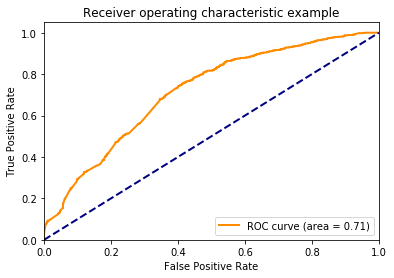

In [43]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Comparing accuracy to random baseline

In [44]:
n_questions = score['n questions'].sum()
p = score['correct_outcome'].sum()/n_questions
# Save p
with open('%s/kdd_2005_2005_p.pkl' % folder, 'wb') as pklfile:
    pickle.dump(p, pklfile)

estimated_outcome = np.random.binomial(1, p, n_questions)
acc = (estimated_outcome == np.asarray(outcome_all)).sum()/score['n questions'].sum()
acc

0.6509817197020988

In [45]:
len(old_students)

551

In [33]:
score.sort_values(["AUC"], ascending=False)

,student,AIC,BIC,RMSE,Acc,n questions,LL,correct_outcome,incorrect_outcome,AUC
151,s19Mo891H5,887.215425,1100.574351,0.296885,0.833333,12,-3.607713,10,2,1.0
461,2kb387yOiG,882.661769,710.814450,0.251301,1.000000,5,-1.330884,4,1,1.0
202,qN6WN7C097,883.574054,486.963461,0.454984,0.666667,3,-1.787027,1,2,1.0
477,Y5XkapASsg,882.344485,307.329245,0.463593,0.500000,2,-1.172243,1,1,1.0
219,12ss7J5ug6,881.261546,306.246306,0.275377,1.000000,2,-0.630773,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...
545,nA15DeLBE1,881.595226,306.579986,0.343119,1.000000,2,-0.797613,2,0,NaN
547,w0FMzJORlK,880.713350,0.713350,0.300000,1.000000,1,-0.356675,1,0,NaN
548,1iPV6aca5w,880.846308,0.846308,0.345022,1.000000,1,-0.423154,1,0,NaN
549,66l1WHbu0M,880.775907,0.775907,0.321556,1.000000,1,-0.387953,0,1,NaN


In [34]:
score.sort_values(["Acc"], ascending=False)

,student,AIC,BIC,RMSE,Acc,n questions,LL,correct_outcome,incorrect_outcome,AUC
275,LQDsuDw2tX,881.920806,485.310213,0.278994,1.0,3,-0.960403,1,2,1.0
291,b4NIYojEYn,883.798329,792.172495,0.281548,1.0,6,-1.899164,5,1,1.0
327,oqL48822V2,881.639218,306.623978,0.344642,1.0,2,-0.819609,2,0,NaN
326,N4Ab8Bvj98,880.000000,0.000000,0.000000,1.0,1,0.000000,1,0,NaN
324,c6LS9kDJe1,881.070175,1.070175,0.414382,1.0,1,-0.535087,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...
58,jbw83hRJZQ,883.192517,3.192517,0.797347,0.0,1,-1.596259,0,1,NaN
357,h31E235Th5,885.972086,489.361493,0.628372,0.0,3,-2.986043,2,1,0.0
311,dVqVsN8nD8,885.237698,310.222458,0.726579,0.0,2,-2.618849,1,1,0.0
1,19UbXBlPPK,881.518107,1.518107,0.531891,0.0,1,-0.759053,1,0,NaN


### Save to file

In [18]:
with open('%s/algebra_2005_2006.txt' % folder, 'r') as test_file:
    rows = test_file.read().split('\n')
rows = rows[:-1]
len(rows)

3968

In [19]:
for idx, row in enumerate(rows):
    if idx == 0:
        outcome_prob = "%s\n" % row
    else:
        try:
            idx_df = df[df["Row"] == int(row)].index.values.astype(int)[0]
            outcome_prob += "%s%s\n" % (row, predicted_proba[idx_df])
        except (IndexError):
#             print(row)
#             random_outcome = np.random.normal(loc=p)
#             if random_outcome > 1:
#                 random_outcome = 1
#             elif random_outcome < 0:
#                 random_outcome = 0
            outcome_prob += "%s1.0\n" % (row)

# predicted_proba_str = ["%s%s" % (rows[idx+1], str(item)) for idx,item in enumerate(predicted_proba)]
# outcome_prob = "Row\tCorrect First Attempt\n"
# outcome_prob += "\n".join(predicted_proba_str)
with open('%s/algebra_2005_2006_test_probabilities.txt' % folder, 'w') as results_file:
    results_file.write(outcome_prob)